In [1]:
import sys
import warnings
import os
if not sys.warnoptions:
    warnings.simplefilter('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from copy import deepcopy as copy
from torch.utils.data import DataLoader, TensorDataset
sns.set()
def seed_torch(seed=1122):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_torch()

# Loading the data

In [2]:
class GetData:
    def __init__(self, batch_size=20, n=5):
        path = '../数据预处理/种植业除语法树.csv'
        sh02 = pd.read_csv(path)
        sh02.drop(labels=['Unnamed: 0','code'],axis=1,inplace=True)
        sh02 = sh02.fillna(0)
        sh02 = sh02.set_index('date')
        self.data = sh02
        self.batch_size = batch_size
        self.n = n
        
    def getData(self):
        self.close_min = self.data['close'].min()
        self.close_max = self.data["close"].max()
        self.data = self.data.apply(lambda x: (x - min(x)) / (max(x) - min(x)))
        return self.data
    
    def process_data(self):
        n = self.n
        self.getData()
#         feature = []
#         label = []
#         for i in range(len(self.data) - n + 2):
#             if i + n < len(self.data):
#                 feature.append(self.data.iloc[i: i + n].values.tolist())
#                 label.append(self.data.close.values[i + n])
        feature = [
            self.data.iloc[i: i + n].values.tolist()
            for i in range(len(self.data) - n + 2)
            if i + n < len(self.data)
        ]
        label = [
            self.data.close.values[i + n]
            for i in range(len(self.data) - n + 2)
            if i + n < len(self.data)
        ]
        num = int(len(feature) * 0.9)
        train_x = feature[:num]
        test_x = feature[num:]
        train_y = label[:num]
        test_y = label[num:]
        return train_x, test_x, train_y, test_y
    
    def get_dataloader(self):
        batch_size = self.batch_size
        train_x, test_x, train_y, test_y = self.process_data()
        x_train = torch.tensor(train_x).float()
        x_test = torch.tensor(test_x).float()
        y_train = torch.tensor(train_y).float()
        y_test = torch.tensor(test_y).float()
        train_data = TensorDataset(x_train, y_train)
        train_dataLoader = DataLoader(train_data, batch_size=batch_size)
        test_data = TensorDataset(x_test, y_test)
        test_dataLoader = DataLoader(test_data, batch_size=batch_size)
        return train_data, test_data

1）输入层

2）卷积层（里面有padding）

3）激活层

4）池化层（里面有padding）

5）全连接FC层

**cnn结构：**


|layer|output shape|
|---|---|
|conv2d|None,5,5,32|
|max_pooling2d|None,2,2,32|
|conv2d|None,2,2,16|
|max_pooling2d|None,1,1,16|
|flatten|None,16|
|dense|None,128|
|dropout|None,128|
|dense|None,1|

In [3]:
class CNNmodel(nn.Module):
    def __init__(self):
        super(CNNmodel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # 输入通道是1，输出通道是第二个参数，第三个参数是卷积核大小
        # 输出维度根据输入维度和卷积核大小计算
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1) # 参数含义同上
        self.fc1 = nn.Linear(176, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        #print('【【【【【【forward】】】】】】】】】】')
        x = torch.unsqueeze(x, dim=1)  
        #print(str(x.shape)) # torch.Size([20, 1, 5, 5])
        x = self.conv1(x)
        #print(str(x.shape)) # torch.Size([20, 32, 3, 3])
        x = F.relu(x)
        #print(str(x.shape)) # torch.Size([20, 32, 3, 3])
        x = F.max_pool2d(x, 2)
        #print(str(x.shape)) # torch.Size([20, 32, 1, 1])
        #print("[[[[[第一次卷积结束]]]]]")
        x = self.conv2(x)
        #print(str(x.shape))  # torch.Size([20, 16, 2, 2])
        x = F.relu(x)
        #print(str(x.shape))  # torch.Size([20, 16, 2, 2])
        x = F.max_pool2d(x, 2)
        #print(str(x.shape))  # torch.Size([20, 16, 1, 1])
        #print("[[[[[第二次卷积结束]]]]]")
        # view函数将张量x变形成一维向量形式，总特征数不变，为全连接层做准备
        x = x.view(x.size()[0], -1)
        #print(str(x.shape))  # torch.Size([20, 16])
        x = F.relu(self.fc1(x))
        #print(str(x.shape))  # torch.Size([20, 128])
        x = F.relu(self.fc2(x))
        #print(str(x.shape))  # torch.Size([20, 64])
        x = self.fc3(x)
        #print(str(x.shape))  # torch.Size([20, 1])
        return x

In [4]:
class CNNmodel2(nn.Module):
    def __init__(self):
        super(CNNmodel2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # 输入通道是1，输出通道是第二个参数，第三个参数是卷积核大小
        # 输出维度根据输入维度和卷积核大小计算
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1) # 参数含义同上
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        self.fc1 = nn.Linear(40, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        #print('【【【【【【forward】】】】】】】】】】')
        x = torch.unsqueeze(x, dim=1)  
        #print(str(x.shape)) # torch.Size([20, 1, 5, 5])
        x = self.conv1(x)
        #print(str(x.shape)) # torch.Size([20, 32, 3, 3])
        x = F.relu(x)
        #print(str(x.shape)) # torch.Size([20, 32, 3, 3])
        x = F.max_pool2d(x, 2)
        #print(str(x.shape)) # torch.Size([20, 32, 1, 1])
        #print("[[[[[第一次卷积结束]]]]]")
        x = self.conv2(x)
        #print(str(x.shape))  # torch.Size([20, 16, 2, 2])
        x = F.relu(x)
        #print(str(x.shape))  # torch.Size([20, 16, 2, 2])
        x = F.max_pool2d(x, 2)
        #print(str(x.shape))  # torch.Size([20, 16, 1, 1])
        #print("[[[[[第二次卷积结束]]]]]")
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        # view函数将张量x变形成一维向量形式，总特征数不变，为全连接层做准备
        x = x.view(x.size()[0], -1)
        #print(str(x.shape))  # torch.Size([20, 16])
        x = F.relu(self.fc1(x))
        #print(str(x.shape))  # torch.Size([20, 128])
        x = F.relu(self.fc2(x))
        #print(str(x.shape))  # torch.Size([20, 64])
        x = self.fc3(x)
        #print(str(x.shape))  # torch.Size([20, 1])
        return x

In [5]:
def train_model(epoch, train_dataLoader, test_dataLoader):
    # 训练模型
    best_model = None
    train_loss = 0
    test_loss = 0
    best_loss = 100
    epoch_cnt = 0
    for _ in range(epoch):
        total_train_loss = 0
        total_train_num = 0
        total_test_loss = 0
        total_test_num = 0
        for x, y in tqdm(train_dataLoader,
                         desc='Epoch: {}| Train Loss: {}| Test Loss: {}'.format(_, train_loss, test_loss)):
            x_num = len(x)
            y = torch.unsqueeze(y, dim=1)  
            p = model(x)
            loss = loss_func(p, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            total_train_num += x_num
        train_loss = total_train_loss / total_train_num
        train_loss_list.append(train_loss)
        for x, y in test_dataLoader:
            x_num = len(x)
            p = model(x)
            loss = loss_func(p, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_test_loss += loss.item()
            total_test_num += x_num
        test_loss = total_test_loss / total_test_num
        test_loss_list.append(test_loss)
        
        # early stop
        if best_loss > test_loss:
            best_loss = test_loss
            best_model = copy(model)
            torch.save(best_model.state_dict(), 'cnn_.pth')
            epoch_cnt = 0
        else:
            epoch_cnt += 1
            
        if epoch_cnt > early_stop:
            torch.save(best_model.state_dict(), 'cnn_.pth')
            print("保存模型")
            #print(best_model.state_dict())
            break

In [6]:
def test_model(test_dataLoader_):
    pred = []
    label = []
    model_ = CNNmodel()
    model_.load_state_dict(torch.load("cnn_.pth"))
    model_.eval()
    total_test_loss = 0
    total_test_num = 0
    for x, y in test_dataLoader_:
        x_num = len(x)
        p = model_(x)
#         print('##', len(p), len(y))
        loss = loss_func(p, y)
        total_test_loss += loss.item()
        total_test_num += x_num
        pred.extend(p.data.squeeze(1).tolist())
        label.extend(y.tolist())
    test_loss = total_test_loss / total_test_num
    # print('##', len(pred), len(label))
    return pred, label,test_loss, test_loss_list

In [7]:
def plot_img(data, pred):
    plt.figure(figsize=(50, 25))
    plt.plot(range(len(pred)), pred, color='green')
    # plt.plot(range(len(data)), data)
    plt.plot(range(len(data)), data, color='b')
    for i in range(0, len(pred)-3, 5):
        price = [data[i]+pred[j]-pred[i] for j in range(i, i+3)]
        plt.plot(range(i, i+3), price, color='r')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close', fontsize=18)
    plt.show()

Epoch: 0| Train Loss: 0| Test Loss: 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 624/624 [00:15<00:00, 39.60it/s]
Epoch: 1| Train Loss: 0.0006697244847185572| Test Loss: 0.0010366473358549763: 100%|███████████████████████████████████████████████████████| 624/624 [00:18<00:00, 34.30it/s]
Epoch: 2| Train Loss: 0.0006832046008277557| Test Loss: 0.0008584894103930744: 100%|███████████████████████████████████████████████████████| 624/624 [00:18<00:00, 33.42it/s]
Epoch: 3| Train Loss: 0.00015217969492629512| Test Loss: 0.00011897253593582766: 100%|█████████████████████████████████████████████████████| 624/624 [21:14<00:00,  2.04s/it]
Epoch: 4| Train Loss: 5.613363085393431e-05| Test Loss: 0.00010551054616678283: 100%|██████████████████████████████████████████████████████| 624/624 [00:20<00:00, 29.94it/s]
Epoch: 5| Train Loss: 4.84393381769209e-05| Test Loss: 0.00016641584420458346: 100%|██████████████████████████████████████████████

保存模型


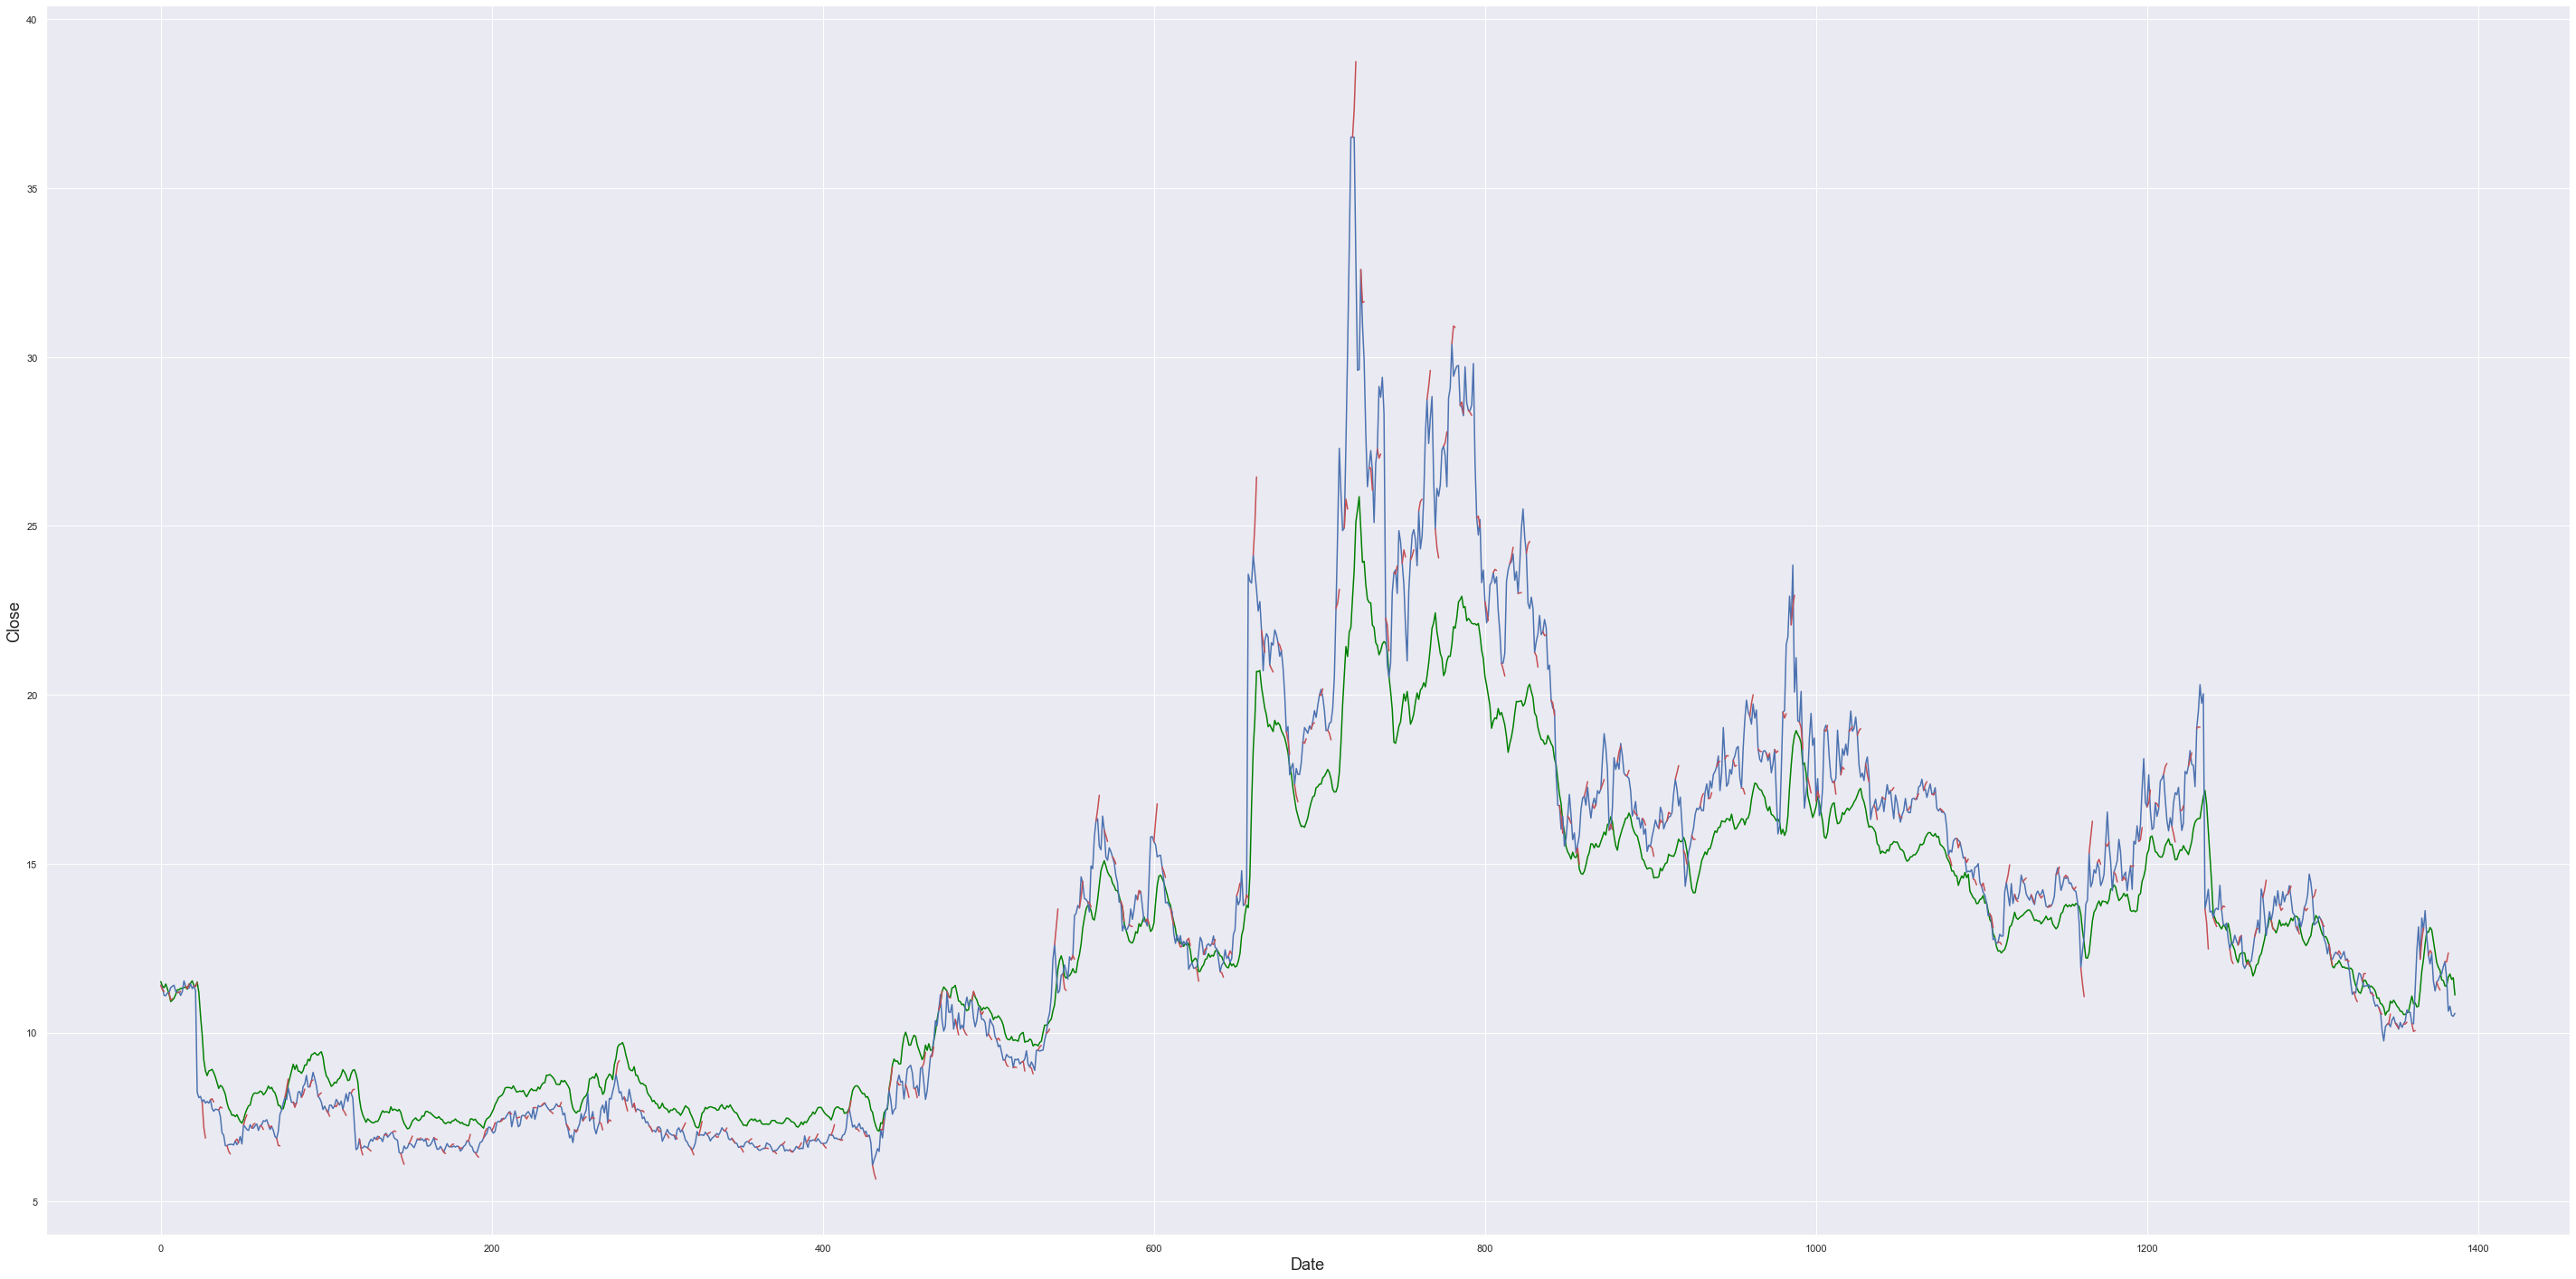

In [8]:
if __name__ == '__main__':
    test_loss_list = []
    train_loss_list = []
    # 参数
    days_num = 5
    epoch = 20
    fea = 5
    batch_size = 20
    early_stop = 5
    
    # 初始化模型
    model = CNNmodel()
    
    # 数据处理部分
    GD = GetData()
    train_x, test_x, train_y, test_y = GD.process_data()
    # print(x_train)
    x_train = torch.tensor(train_x).float()
    x_test = torch.tensor(test_x).float()
    y_train = torch.tensor(train_y).float()
    y_test = torch.tensor(test_y).float()
    train_data = TensorDataset(x_train, y_train)
    train_dataLoader = DataLoader(train_data, batch_size=batch_size)
    test_data = TensorDataset(x_test, y_test)
    test_dataLoader = DataLoader(test_data, batch_size=batch_size)

    
    # 损失函数和优化器
    loss_func = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(epoch, train_dataLoader, test_dataLoader)
    p, y, test_loss, test_loss_list = test_model(test_dataLoader)
    
    # 画图
    pred = [ele * (GD.close_max - GD.close_min) + GD.close_min for ele in p]
    data = [ele * (GD.close_max - GD.close_min) + GD.close_min for ele in y]
    
    plot_img(data, pred)

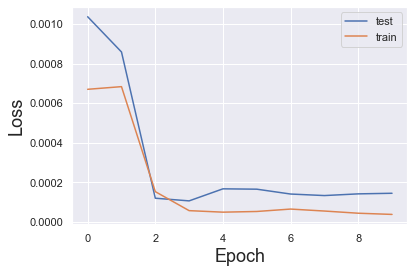

In [11]:
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.plot(test_loss_list)
plt.plot(train_loss_list)
plt.legend(["test","train"])

In [12]:
from get_rr import goodness_of_fit
rr = goodness_of_fit(pred, data)
rr

0.5197576144123981